Kita akan belajar membuat sistem rekomendasi dengan menggunakan Python, data yang akan kita gunakan di sini adalah database film dari imdb lengkap dengan metadatanya
Mentor: Karl Christian Business Intelligence Traveloka

Latar Belakang<bR>
Terdapat 2 dasar tipe sistem rekomendasi:

Sistem Rekomendasi Sederhana
Sistem Rekomendasi Berdasarkan Konten dari Fiturnya
 
Sistem Rekomendasi Sederhana, seperti namanya adalah sistem rekomendasi yang hanya menggunakan urutan sebagai dasar perhitungannya, yang biasanya digunakan dalam '5 film terbaik' kita akan menggunakan urutan berdasarkan mungkin vote terbanyak, rating tertinggi, penjualan film paling tinggi, atau apapun yang lain.
Dalam kasus ini, kita akan menggunakan kombinasi antara rata-rata rating, jumlah vote, dan membentuk metric baru dari metric yang sudah ada, kemudian kita akan melakukan sorting untuk metric ini dari yang tertinggi ke terendah.

Simple Recommender Engine using Weighted Average<br>
Simple Recommender Engine menawarkan rekomendasi yang umum untuk semua user berdasarkan popularitas film dan terkadang genre.

Ide awal di balik sistem rekomendasi ini adalah sebagai berikut.

- Film-film yang lebih populer akan memiliki kemungkinan yang lebih besar untuk disukai juga oleh rata-rata penonton.
- Model ini tidak memberikan rekomendasi yang personal untuk setiap tipe user. 
- Implementasi model ini pun juga bisa dibilang cukup mudah, yang perlu kita lakukan hanyalah mengurutkan film-film tersebut berdasarkan rating dan popularitas dan menunjukkan film teratas dari list film tersebut.


Sebagai tambahan, kita dapat menambahkan genre untuk mendapatkan film teratas untuk genre spesifik tersebut



Formula dari IMDB dengan Weighted Rating
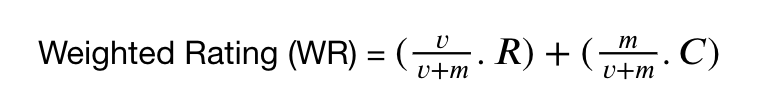

dimana,

- v: jumlah votes untuk film tersebut
- m: jumlah minimum votes yang dibutuhkan supaya dapat masuk dalam chart
- R: rata-rata rating dari film tersebut
- C: rata-rata jumlah votes dari seluruh semesta film

Task 1 - Library Import and File Unloading<br>
Pekerjaan pertama yang harus dilakukan adalah melakukan import library dan membaca dataset yang akan digunakan dalam project ini

data yang digunakan:
    - https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/title.basics.tsv
    - https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/title.ratings.tsv

In [1]:
#import library yang dibutuhkan
import pandas as pd
import numpy as np

#lakukan pembacaan dataset
movie_df = pd.read_csv('../title.basics.tsv', sep='\t') #untuk menyimpan title_basics.tsv
rating_df = pd.read_csv('../title.ratings.tsv', sep='\t') #untuk menyimpan title.ratings.tsv

In [2]:
movie_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0221078,short,"Circle Dance, Ute Indians","Circle Dance, Ute Indians",0,1898,\N,\N,"Documentary,Short"
1,tt8862466,tvEpisode,"¡El #TeamOsos va con todo al ""Reality del amor""!","¡El #TeamOsos va con todo al ""Reality del amor""!",0,2018,\N,\N,"Comedy,Drama"
2,tt7157720,tvEpisode,Episode #3.41,Episode #3.41,0,2016,\N,29,"Comedy,Game-Show"
3,tt2974998,tvEpisode,Episode dated 16 May 1987,Episode dated 16 May 1987,0,1987,\N,\N,News
4,tt2903620,tvEpisode,Frances Bavier: Aunt Bee Retires,Frances Bavier: Aunt Bee Retires,0,1973,\N,\N,Documentary


In [3]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9025 entries, 0 to 9024
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tconst          9025 non-null   object
 1   titleType       9025 non-null   object
 2   primaryTitle    9011 non-null   object
 3   originalTitle   9011 non-null   object
 4   isAdult         9025 non-null   int64 
 5   startYear       9025 non-null   object
 6   endYear         9025 non-null   object
 7   runtimeMinutes  9025 non-null   object
 8   genres          9014 non-null   object
dtypes: int64(1), object(8)
memory usage: 634.7+ KB


<h3> Cleaning Table Movie </h3>

Pengecekan Data dengan Nilai NULL<br>
Merupakan suatu hal yang wajib untuk melakukan pengecekan terhadap nilai NULL yang ada di dalam dataset saat melakukan cleaning.

Oleh karena itu, hal selanjutnya yang akan kita lakukan adalah melakukan pengecekan apakah ada data bernilai NULL pada masing-masing kolom yang ada pada table movie (movie_df)

In [4]:
movie_df.isnull().sum()

tconst             0
titleType          0
primaryTitle      14
originalTitle     14
isAdult            0
startYear          0
endYear            0
runtimeMinutes     0
genres            11
dtype: int64

Analisis Kolom dengan data bernilai NULL - part 1<br>
Dari hasil pengecekan nilai NULL yang sudah dilakukan sebelumnya, diketahui bahwa kolom 'primaryTitle' dan 'originalTitle' memiliki banyak data yang bernilai NULL.

Hal selanjutnya yang akan kita lakukan adalah melakukan pengecekan terhadap bentuk data dari kolom primaryTitle dan originalTitle yang bernilai NULL. 

In [5]:
movie_df.loc[(movie_df['primaryTitle'].isnull()) | (movie_df['originalTitle'].isnull())]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
9000,tt10790040,tvEpisode,NaN,NaN,0,2019,\N,\N,\N
9001,tt10891902,tvEpisode,NaN,NaN,0,2020,\N,\N,Crime
9002,tt11737860,tvEpisode,NaN,NaN,0,2020,\N,\N,"Comedy,Drama,Romance"
9003,tt11737862,tvEpisode,NaN,NaN,0,2020,\N,\N,"Comedy,Drama,Romance"
9004,tt11737866,tvEpisode,NaN,NaN,0,2020,\N,\N,"Comedy,Drama,Romance"
9005,tt11737872,tvEpisode,NaN,NaN,0,2020,\N,\N,\N
9006,tt11737874,tvEpisode,NaN,NaN,0,2020,\N,\N,"Comedy,Drama,Romance"
9007,tt1971246,tvEpisode,NaN,NaN,0,2011,\N,\N,Biography
9008,tt2067043,tvEpisode,NaN,NaN,0,1965,\N,\N,Music
9009,tt4404732,tvEpisode,NaN,NaN,0,2015,\N,\N,Comedy


Membuang Data dengan Nilai NULL - part 1<br>
Setelah melihat hasil sebelumnya, dapat dilihat bahwa semua data tidak memiliki judul dan kita dapat membuang data-data tersebut.

Pekerjaan selanjutnya yang akan kita lakukan adalah membuang data dengan nilai NULL tersebut dan melihat jumlah data yang ada setelah data-data bernilai NULL tersebut dibuang. 

In [6]:
#mengupdate movie_df dengan membuang data-data bernilai NULL
movie_df = movie_df.loc[(movie_df['primaryTitle'].notnull()) & (movie_df['originalTitle'].notnull())]

#menampilkan jumlah data setelah data dengan nilai NULL dibuang
len(movie_df)

9011

Analisis Kolom dengan data bernilai NULL - part 2<br>
Selain kolom 'primaryTitle' dan 'originalTitle',masih terdapat kolom lain yang memiliki data bernilai NULL. Kolom tersebut adalah kolom 'genres'

Selanjutnya, kita akan melakukan hal yang sama seperti yang sudah kita lakukan pada kolom 'primaryTitle' dan 'originalTitle'.

Lakukan pengecekan terhadap bentuk data dari kolom genres yang bernilai NULL. 

In [7]:
movie_df.loc[movie_df['genres'].isnull()]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
9014,tt10233364,tvEpisode,Rolling in the Deep Dish\tRolling in the Deep ...,0,2019,\N,\N,Reality-TV,NaN
9015,tt10925142,tvEpisode,The IMDb Show on Location: Star Wars Galaxy's ...,0,2019,\N,\N,Talk-Show,NaN
9016,tt10970874,tvEpisode,Die Bauhaus-Stadt Tel Aviv - Vorbild für die M...,0,2019,\N,\N,\N,NaN
9017,tt11670006,tvEpisode,...ein angenehmer Unbequemer...\t...ein angene...,0,1981,\N,\N,Documentary,NaN
9018,tt11868642,tvEpisode,GGN Heavyweight Championship Lungs With Mike T...,0,2020,\N,\N,Talk-Show,NaN
9019,tt2347742,tvEpisode,No sufras por la alergia esta primavera\tNo su...,0,2004,\N,\N,\N,NaN
9020,tt3984412,tvEpisode,"I'm Not Going to Come Last, I'm Just Going to ...",0,2014,\N,\N,Reality-TV,NaN
9021,tt8740950,tvEpisode,Weight Loss Resolution Restart - Ins & Outs of...,0,2015,\N,\N,Reality-TV,NaN
9022,tt9822816,tvEpisode,Zwischen Vertuschung und Aufklärung - Missbrau...,0,2019,\N,\N,\N,NaN
9023,tt9900062,tvEpisode,The Direction of Yuu's Love: Hings Aren't Goin...,0,1994,\N,\N,"Animation,Comedy,Drama",NaN


Membuang Data dengan Nilai NULL - part 2<br>
Setelah melihat hasil sebelumnya, dapat dilihat bahwa semua data tidak memiliki judul dan kita dapat membuang data-data tersebut.Pekerjaan selanjutnya yang akan kita lakukan adalah membuang data dengan nilai NULL tersebut dan melihat jumlah data yang ada setelah data-data bernilai NULL tersebut dibuang. 

In [8]:
#mengupdate movie_df dengan membuang data-data bernilai NULL
movie_df = movie_df.loc[movie_df['genres'].notnull()]

#menampilkan jumlah data setelah data dengan nilai NULL dibuang
print(len(movie_df))

9000


Mengubah Nilai '\\N'<br>
Jika kita perhatikan pada kolom 'startYear' , 'endYear', dan 'runtimeMinutes', terdapat data dengan nilai '\\N'

'\\N' berarti NULL.

Hal selanjutnya yang akan kita lakukan adalah mengubah nilai dari \\\N tersebur menjadi np.nan dan melakukan casting kolom startYear, endYear, dan runtimeMinutes menjadi float64.

In [9]:
#mengubah nilai '\\N' pada startYear menjadi np.nan dan cast kolomnya menjadi float64
movie_df['startYear'] = movie_df['startYear']. replace('\\N', np.nan)
movie_df['startYear'] = movie_df['startYear']. astype('float64')
print(movie_df['startYear'].unique()[:5])

#mengubah nilai '\\N' pada endYear menjadi np.nan dan cast kolomnya menjadi float64
movie_df['endYear'] = movie_df['endYear']. replace('\\N', np.nan)
movie_df['endYear'] = movie_df['endYear']. astype('float64')
print(movie_df['endYear'].unique()[:5])

#mengubah nilai '\\N' pada runtimeMinutes menjadi np.nan dan cast kolomnya menjadi float64
movie_df['runtimeMinutes'] = movie_df['runtimeMinutes']. replace('\\N', np.nan)
movie_df['runtimeMinutes'] = movie_df['runtimeMinutes']. astype('float64')
print(movie_df['runtimeMinutes'].unique()[:5])

[1898. 2018. 2016. 1987. 1973.]
[  nan 2005. 1955. 2006. 1999.]
[nan 29.  7. 23. 85.]


Mengubah nilai genres menjadi list<br>
Selanjutnya, kita akan membuat sebuah function yang bernama transform_to_list untuk mengubah nilai genre menjadi list. 

In [10]:
def transform_to_list(x):
    if ',' in x: 
    #ubah menjadi list apabila ada data pada kolom genre
        return x.split(',')
    else: 
    #jika tidak ada data, ubah menjadi list kosong
        return []

movie_df['genres'] = movie_df['genres'].apply(lambda x: transform_to_list(x))

<h3>Cleaning table ratings</h3>

In [11]:
rating_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1608
1,tt0000002,6.0,197
2,tt0000003,6.5,1285
3,tt0000004,6.1,121
4,tt0000005,6.1,2050


In [12]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030009 entries, 0 to 1030008
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1030009 non-null  object 
 1   averageRating  1030009 non-null  float64
 2   numVotes       1030009 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ MB


<h3>Joining table movie and table ratings</h3>

Inner Join table movie dan table rating<br>
Mari kita melakukan inner join antara rating_df dan movie_df untuk mendapatkan rating pada setiap film yang tersedia, lalu tampilkan 5 data teratas dan tipe data dari tiap kolom yang ada. 

In [15]:
#Lakukan join pada kedua table
movie_rating_df = pd.merge(movie_df, rating_df, on='tconst', how='inner')

#Tampilkan 5 data teratas
movie_rating_df.head()


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0043745,short,Lion Down,Lion Down,0,1951.0,NaN,7.0,"[Animation, Comedy, Family]",7.1,459
1,tt0167491,video,Wicked Covergirls,Wicked Covergirls,1,1998.0,NaN,85.0,[],5.7,7
2,tt6574096,tvEpisode,Shadow Play - Part 2,Shadow Play - Part 2,0,2017.0,NaN,22.0,"[Adventure, Animation, Comedy]",8.5,240
3,tt6941700,tvEpisode,RuPaul Roast,RuPaul Roast,0,2017.0,NaN,NaN,[],8.0,11
4,tt7305674,video,UCLA Track & Field Promo,UCLA Track & Field Promo,0,2017.0,NaN,NaN,"[Short, Sport]",9.7,7


In [16]:
#Tampilkan tipe data dari tiap kolom
movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376 entries, 0 to 1375
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          1376 non-null   object 
 1   titleType       1376 non-null   object 
 2   primaryTitle    1376 non-null   object 
 3   originalTitle   1376 non-null   object 
 4   isAdult         1376 non-null   int64  
 5   startYear       1376 non-null   float64
 6   endYear         26 non-null     float64
 7   runtimeMinutes  1004 non-null   float64
 8   genres          1376 non-null   object 
 9   averageRating   1376 non-null   float64
 10  numVotes        1376 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 129.0+ KB


Memperkecil ukuran Table<br>
Hal selanjutnya yang akan kita lakukan adalah memperkecil ukuran table dengan menghilangkan semua nilai NULL dari kolom startYear dan runtimeMinutes karena tidak masuk akal jikalau film tersebut tidak diketahui kapan tahun rilis dan durasi nya. 

In [17]:
movie_rating_df = movie_rating_df.dropna(subset=['startYear','runtimeMinutes'])

#Untuk memastikan bahwa sudah tidak ada lagi nilai NULL
movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1004 entries, 0 to 1374
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          1004 non-null   object 
 1   titleType       1004 non-null   object 
 2   primaryTitle    1004 non-null   object 
 3   originalTitle   1004 non-null   object 
 4   isAdult         1004 non-null   int64  
 5   startYear       1004 non-null   float64
 6   endYear         17 non-null     float64
 7   runtimeMinutes  1004 non-null   float64
 8   genres          1004 non-null   object 
 9   averageRating   1004 non-null   float64
 10  numVotes        1004 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 94.1+ KB


<h3> Building Simple Recommender System </h3>
kembali ke formula IMDB weighted average, kita sudah memiliki value v dan R. Sekarang kita perlu mencari untuk value C dan m

In [18]:
C = movie_rating_df['averageRating'].mean()
print(C)

6.829581673306767


In [19]:
m = movie_rating_df['numVotes'].quantile(0.8)
print(m)

229.0


In [22]:
#membuat fingsinya
def imdb_weighted_rating(df, var=0.8):
    v = df['numVotes']
    R = df['averageRating']
    C = df['averageRating'].mean()
    m = df['numVotes'].quantile(var)
    df['score'] = (v/(m+v))*R + (m/(m+v))*C #Rumus IMDb 
    return df['score']


In [25]:
imdb_weighted_rating(movie_rating_df)

#melakukan pengecekan dataframe
movie_rating_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,score
0,tt0043745,short,Lion Down,Lion Down,0,1951.0,NaN,7.0,"[Animation, Comedy, Family]",7.1,459,7.009992
1,tt0167491,video,Wicked Covergirls,Wicked Covergirls,1,1998.0,NaN,85.0,[],5.7,7,6.796077
2,tt6574096,tvEpisode,Shadow Play - Part 2,Shadow Play - Part 2,0,2017.0,NaN,22.0,"[Adventure, Animation, Comedy]",8.5,240,7.684380
5,tt2262289,movie,The Pin,The Pin,0,2013.0,NaN,85.0,[],7.7,27,6.921384
6,tt0874027,tvEpisode,Episode #32.9,Episode #32.9,0,2006.0,NaN,29.0,"[Comedy, Game-Show, News]",8.0,8,6.869089


cara membuat simple recommender system<br>
Dari task yang sudah kita lakukan sebelumnya, telah terdapat field tambahan 'score'.

Pertama kita akan filter numVotes yang lebih dari m kemudian diurutkan score dari tertinggi ke terendah untuk diambil nilai beberapa nilai teratas

In [28]:
def simple_recommender(df, top=100):
    df = df.loc[df['numVotes'] >= m]
    df = df.sort_values(by='score', ascending = False) #urutkan dari nilai tertinggi ke terendah
    
    #Ambil data 100 teratas
    df = df[:top]
    return df


In [30]:
#Ambil data 25 teratas     
simple_recommender(movie_rating_df, top=25)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,score
68,tt4110822,tvEpisode,S.O.S. Part 2,S.O.S. Part 2,0,2015.0,NaN,43.0,"[Action, Adventure, Drama]",9.4,3820,9.254624
236,tt2200252,video,Attack of the Clones Review,Attack of the Clones Review,0,2010.0,NaN,86.0,[],9.3,1411,8.955045
1181,tt7697962,tvEpisode,Chapter Seventeen: The Missionaries,Chapter Seventeen: The Missionaries,0,2019.0,NaN,54.0,"[Drama, Fantasy, Horror]",9.2,1536,8.892450
326,tt7124590,tvEpisode,Chapter Thirty-Four: Judgment Night,Chapter Thirty-Four: Judgment Night,0,2018.0,NaN,42.0,"[Crime, Drama, Mystery]",9.1,1859,8.850993
1045,tt0533506,tvEpisode,The Prom,The Prom,0,1999.0,NaN,60.0,"[Action, Drama, Fantasy]",8.9,2740,8.740308
71,tt8399426,tvEpisode,Savages,Savages,0,2018.0,NaN,58.0,"[Drama, Fantasy, Romance]",9.0,1428,8.700045
1234,tt2843830,tvEpisode,VIII.,VIII.,0,2014.0,NaN,57.0,"[Adventure, Drama]",8.9,1753,8.660784
1087,tt4295140,tvSeries,Chef's Table,Chef's Table,0,2015.0,NaN,50.0,[],8.6,12056,8.566998
1054,tt2503932,tvEpisode,Trial and Error,Trial and Error,0,2013.0,NaN,43.0,"[Drama, Fantasy, Horror]",8.6,2495,8.451165
448,tt0337566,video,AC/DC: Live at Donington,AC/DC: Live at Donington,0,1992.0,NaN,120.0,"[Documentary, Music]",8.5,1343,8.256663


Cara membuat simple recommender system dengan user preferences<br>
Dari task yang sudah dilakukan sebelumnya, dapat dilihat sekarang daftar film telah diurutkan dari score tertinggi ke terendah.

Film dengan averageRating yang tinggi tidak selalu mendapat posisi yang lebih tinggi dibanding film dengan averageRating lebih rendah, hal ini disebabkan karena kita juga memperhitungkan faktor banyaknya votes


Sistem rekomendasi ini masih bisa ditingkatkan dengan menambah filter spesifik tentang titleType, startYear, ataupun filter yang lain

Pekerjaan selanjutnya yang akan kita lakukan adalah membuat function untuk melakukan filter berdasarkan isAdult, startYear, dan genres. 

In [32]:
df = movie_rating_df.copy()

def user_prefer_recommender(df, ask_adult, ask_start_year, ask_genre, top=100):
    #ask_adult = yes/no
    if ask_adult.lower() == 'yes':
        df = df.loc[df['isAdult'] == 1]
    elif ask_adult.lower() == 'no':
        df = df.loc[df['isAdult'] == 0]

    #ask_start_year = numeric
    df = df.loc[df['startYear'] >= int(ask_start_year)]

    #ask_genre = 'all' atau yang lain
    if ask_genre.lower() == 'all':
        df = df
    else:
        def filter_genre(x):
            if ask_genre.lower() in str(x).lower():
                return True
            else:
                return False
        df = df.loc[df['genres'].apply(lambda x: filter_genre(x))]

    df = df.loc[df['numVotes'] >= m] #Mengambil film dengan m yang lebih besar dibanding numVotes
    df = df.sort_values(by='score', ascending=False)
    
    #jika kamu hanya ingin mengambil 100 teratas
    df = df[:top]
    return df


In [33]:
user_prefer_recommender(df,
                       ask_adult = 'no',
                        ask_start_year = 2000,
                       ask_genre = 'drama'
                       )

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,score
68,tt4110822,tvEpisode,S.O.S. Part 2,S.O.S. Part 2,0,2015.0,NaN,43.0,"[Action, Adventure, Drama]",9.4,3820,9.254624
1181,tt7697962,tvEpisode,Chapter Seventeen: The Missionaries,Chapter Seventeen: The Missionaries,0,2019.0,NaN,54.0,"[Drama, Fantasy, Horror]",9.2,1536,8.892450
326,tt7124590,tvEpisode,Chapter Thirty-Four: Judgment Night,Chapter Thirty-Four: Judgment Night,0,2018.0,NaN,42.0,"[Crime, Drama, Mystery]",9.1,1859,8.850993
71,tt8399426,tvEpisode,Savages,Savages,0,2018.0,NaN,58.0,"[Drama, Fantasy, Romance]",9.0,1428,8.700045
1234,tt2843830,tvEpisode,VIII.,VIII.,0,2014.0,NaN,57.0,"[Adventure, Drama]",8.9,1753,8.660784
1054,tt2503932,tvEpisode,Trial and Error,Trial and Error,0,2013.0,NaN,43.0,"[Drama, Fantasy, Horror]",8.6,2495,8.451165
1281,tt3166390,tvEpisode,Looking for a Plus-One,Looking for a Plus-One,0,2014.0,NaN,28.0,"[Comedy, Drama, Romance]",8.7,396,8.014679
151,tt3954426,tvEpisode,Bleeding Kansas,Bleeding Kansas,0,2014.0,NaN,42.0,"[Drama, Western]",8.6,437,7.991253
1344,tt6644294,tvEpisode,The Hostile Hospital: Part Two,The Hostile Hospital: Part Two,0,2018.0,NaN,40.0,"[Adventure, Comedy, Drama]",8.3,812,7.976536
357,tt4084774,tvEpisode,Trial and Punishment,Trial and Punishment,0,2015.0,NaN,56.0,"[Adventure, Drama]",8.8,289,7.928908
